![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

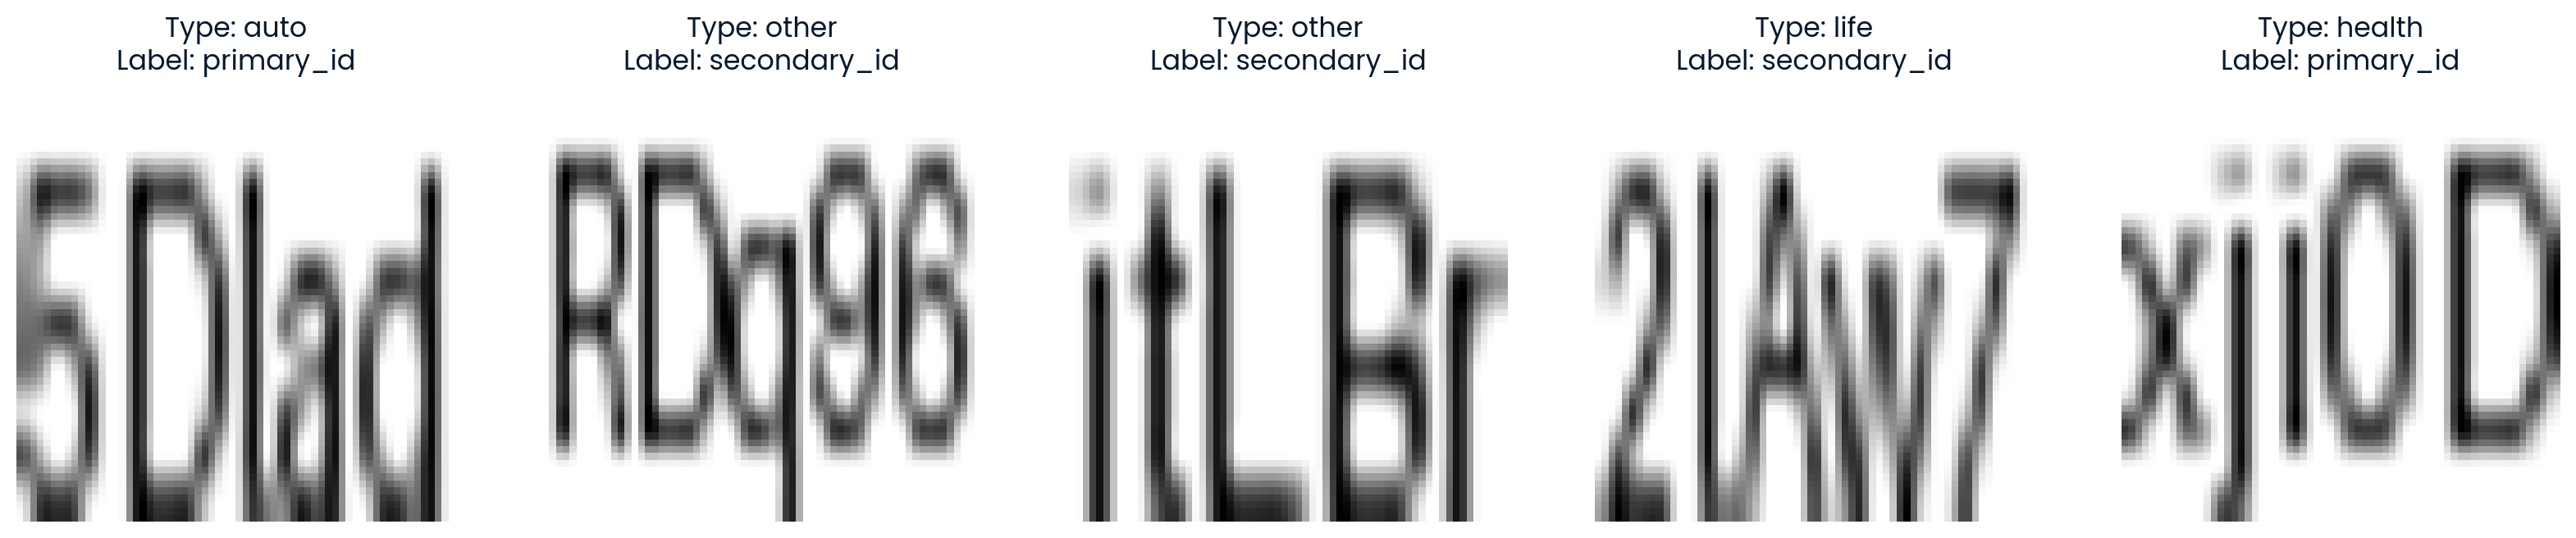

In [13]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [14]:
# Start coding here 

## Imports and dataset provided

In [15]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Define the OCRModel class

In [16]:
class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Image pathway
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # conv
            nn.ReLU(),                                  # activation
            nn.MaxPool2d(2),                            # pooling
            nn.Flatten(),                               # flatten
            nn.Linear(16 * 32 * 32, 128)                # fully connected
        )
        
        # Type pathway
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU()
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 64),   # concat (image 128 + type 10)
            nn.ReLU(),
            nn.Linear(64, 2)           # output: Primary / Secondary
        )

    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image, x_type), dim=1)
        return self.classifier(x)


## Define optimizer & loss

In [17]:
import torch.optim as optim

model = OCRModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Training loop

In [18]:
# Wrap dataset into DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for (inputs, labels) in dataloader:
        # inputs = (image, type)
        images, types = inputs
        # Forward pass
        outputs = model(images, types)
        loss = criterion(outputs, labels)

        # Backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")


Epoch 1/2, Loss: 3.5214
Epoch 2/2, Loss: 2.2123


## Training Accuracy (Evaluation)

In [19]:
# ----- Evaluation (Accuracy on training set) -----
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in dataloader:
        images, types = inputs
        outputs = model(images, types)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = correct / total
print(f"Training Accuracy: {acc:.4f}")


Training Accuracy: 0.4700
